In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from asteroid.models.base_models import BaseModel
import numpy as np
import pandas as pd
import librosa as lr
import soundfile as sf
import matplotlib.pyplot as plt
import time
import os
import os.path
import sys

from librosa import display as lrd
from concurrent.futures import ProcessPoolExecutor
from collections import OrderedDict
from functools import partial
from torch.multiprocessing import Process, Queue, cpu_count
from queue import Empty

from torch.utils.data import DataLoader, ConcatDataset, random_split, Subset
from asteroid.data import TimitDataset
from asteroid.data.utils import CachedWavSet, FixedMixtureSet
from tqdm import trange, tqdm

from asteroid import DCUNet, DCCRNet, DPRNNTasNet, ConvTasNet, RegressionFCNN, WaveUNet, DPTNet
from asteroid.engine.system import UNetGAN

from asteroid.masknn import UNetGANGenerator, UNetGANDiscriminator
from asteroid.utils.notebook_utils import show_wav

sys.path.append('../egs')

from timit_drones.evaluate import evaluate_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
TIMIT_DIR_8kHZ = '/import/vision-eddydata/dm005_tmp/TIMIT_8kHZ'
TEST_NOISE_DIR = '../../../datasets/noises-test-drones'
SAMPLE_RATE    = 8000
TEST_SNRS      = [-30, -25, -20, -15, -10, -5, 0]
SEED           = 42

In [3]:
timit_test_clean = TimitDataset(TIMIT_DIR_8kHZ, subset='test', sample_rate=SAMPLE_RATE, with_path=False)
timit_small = Subset(timit_test_clean, np.arange(len(timit_test_clean)//20))
noises_test = CachedWavSet(TEST_NOISE_DIR, sample_rate=SAMPLE_RATE, precache=True)

Precaching audio: 100%|██████████| 2/2 [00:00<00:00, 184.97it/s]


In [4]:
timit_test_small = FixedMixtureSet(timit_small, noises_test, snrs=TEST_SNRS, random_seed=SEED, with_snr=True)
timit_test = FixedMixtureSet(timit_test_clean, noises_test, snrs=TEST_SNRS, random_seed=SEED, with_snr=True)

In [5]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [20]:
metrics_names = {
    'pesq': 'PESQ',
    'stoi': 'STOI',
    'si_sdr': 'SI-SDR',
}

model_labels = {
    'input': 'Input',
    'baseline': 'Baseline DNN',
    'baseline_v2': 'Baseline DNN (L1 loss)',
    'baseline_proper_mse': 'Baseline DNN (fixed test set)',
    'waveunet_v1': 'Wave-U-Net',
    'dcunet_20': 'DCUNet-20',
    'dccrn': 'DCCRN',
    'dprnn': 'DPRNN',
    'conv_tasnet': 'Conv-TasNet',
    'dptnet': 'DPTNet',
}

def plot_results(dfs, figsize=(15, 5), metrics=['pesq', 'stoi', 'si_sdr'],
                 plot_name=None): 
    
    fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=figsize)
    
    for model_name, df in dfs.items():
        scores = df.groupby('snr').agg({
            metric: ['mean', 'std', 'count'] for metric in metrics
        })
        
        line_kwargs = {'marker': 'o', 'alpha': 0.8}
        fill_kwargs = {}
        if model_name == 'input':
            line_kwargs = {'c': 'black', 'ls': '--'}
            fill_kwargs = {'color': 'black'}
        
        for i, metric in enumerate(metrics):
            plt.sca(axes[i])
            means = scores[metric]['mean']
            stds = scores[metric]['std'].values / np.sqrt(scores[metric]['count'].values) * 3
            xs = means.index
            plt.plot(xs, means, label=model_labels[model_name], **line_kwargs)
            plt.fill_between(xs, means - stds, means + stds, alpha=0.2, **fill_kwargs)
    
    for i, metric in enumerate(metrics):
        plt.sca(axes[i])
        plt.grid(which='both')
        plt.title(metrics_names[metric])
        plt.xlabel('SNR, dB')
        if i == 0:
            plt.legend()
    
    if plot_name is not None:
        plt.savefig(plot_name, bbox_inches='tight')
    
    plt.show()

In [7]:
def demonstrate_models_on_sample(models, mix, clean, **kwargs):
    print('Clean speech')
    show_wav(clean, **kwargs)
    
    for model_name, model in models.items():
        if model is None:
            print('Noisy mixture')
            show_wav(mix, **kwargs)
        else:
            model.eval()
            print(model_labels[model_name])
            show_wav(model(mix).flatten(), **kwargs)

### Models evaluation

In [17]:
models = {
    'input': None,
    'baseline': RegressionFCNN.from_pretrained('../../../workspace/models/baseline_model_v1.pt'),
    #'baseline_v2': RegressionFCNN.from_pretrained('../../../workspace/models/baseline_model_v2.pt'),
    #'baseline_proper_mse': RegressionFCNN.from_pretrained('../../../workspace/models/baseline_model_fixed_mse.pt'),
    'waveunet_v1': WaveUNet.from_pretrained('../../../workspace/models/waveunet_model_adapt.pt'),
    'dcunet_20': DCUNet.from_pretrained('../../../workspace/models/dcunet_20_random_v2.pt'),
    'dccrn': DCCRNet.from_pretrained('../../../workspace/models/dccrn_random_v1.pt'),
    'dprnn': DPRNNTasNet.from_pretrained('../../../workspace/models/dprnn_model.pt'),
    'conv_tasnet': ConvTasNet.from_pretrained('../../../workspace/models/convtasnet_model.pt'),
    'dptnet': DPTNet.from_pretrained('../../../workspace/models/dptnet_model.pt'),
}

In [18]:
mix, clean, snr = timit_test_small[600]
print(snr)

-15


Clean speech


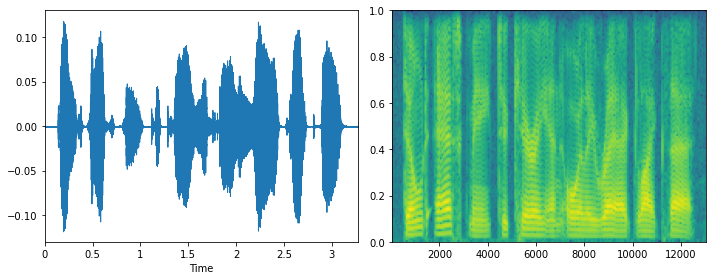

Noisy mixture


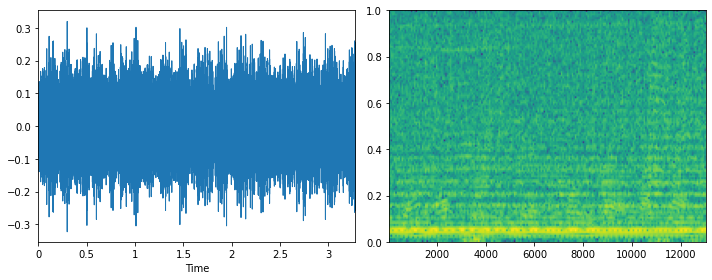

Baseline DNN


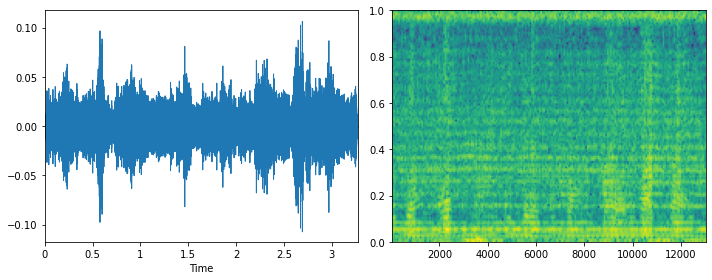

Wave-U-Net


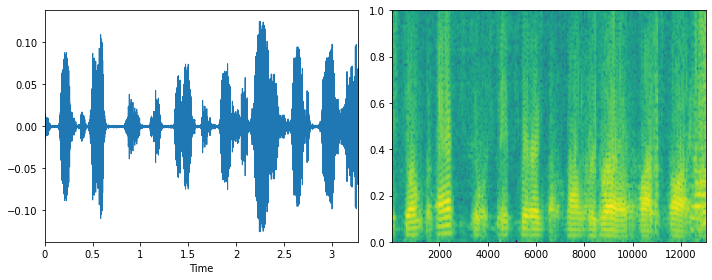

DCUNet-20


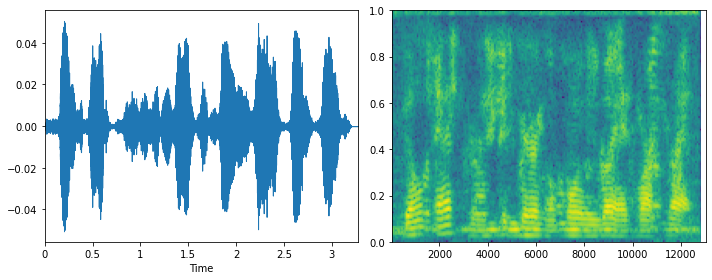

DCCRN


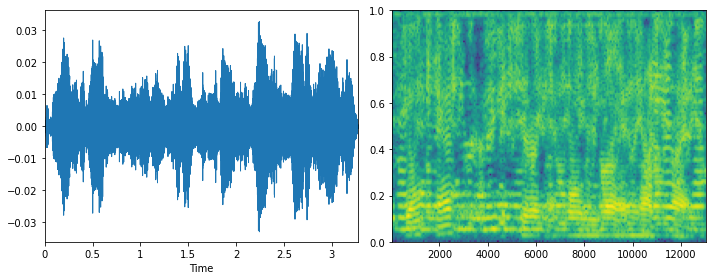

DPRNN


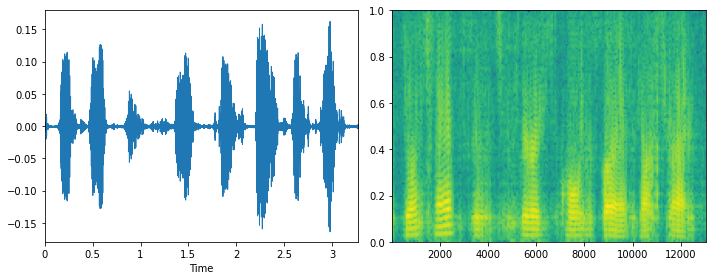

Conv-TasNet


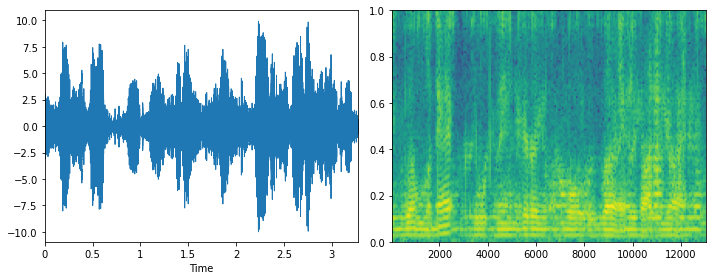

DPTNet


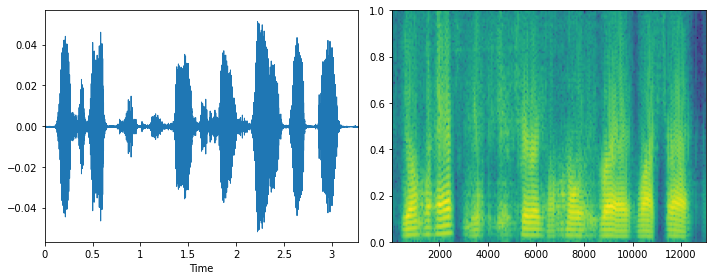

In [21]:
demonstrate_models_on_sample(models, mix, clean, specgram_lib='matplotlib')

In [22]:
def eval_all_and_plot(models, test_set, directory, plot_name):
    results_dfs = {}

    for model_name, model in models.items():
        print(f'Evaluating {model_labels[model_name]}')
        csv_path = f'../../../workspace/{directory}/{model_name}.csv'

        if os.path.isfile(csv_path):
            print('Results already available')
            df = pd.read_csv(csv_path)
        else:
            df = evaluate_model(model, test_set)
            df.to_csv(csv_path, index=False)

        results_dfs[model_name] = df

    plot_results(results_dfs, figsize=(14, 8), plot_name=plot_name)

In [13]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating Wave-U-Net
Results already available
Evaluating DCUNet-20
Results already available
Evaluating DCCRN
Results already available
Evaluating DPRNN
Results already available
Evaluating Conv-TasNet
Results already available
Evaluating DPTNet


Evaluating and calculating scores: 100%|██████████| 23520/23520 [45:17<00:00,  8.65it/s]  


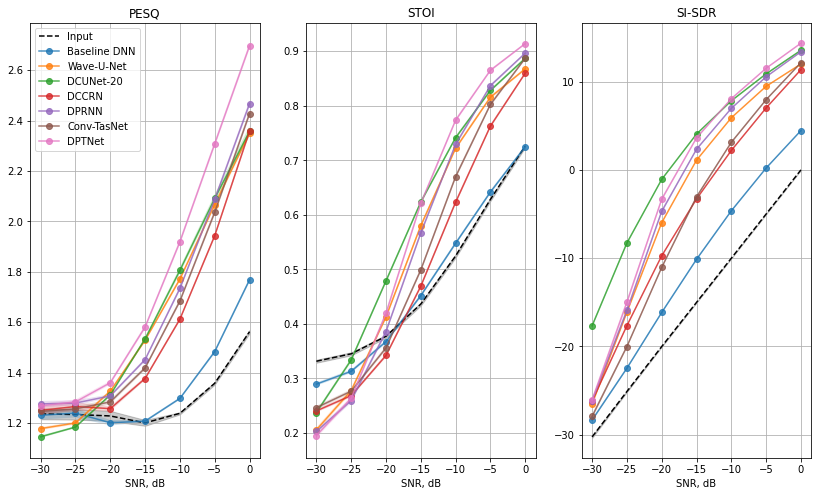

In [23]:
eval_all_and_plot(models, timit_test, 'eval_results_new', 'results_new_v2.pdf')

In [26]:
for model_name, model in models.items():
    if model is None:
        continue
    param_count = sum(p.numel() for p in model.parameters())
    param_approx = np.around(param_count / 1000000, decimals=2)
    print(f'{model_labels[model_name]}: {param_approx}M params')

Baseline DNN: 10.51M params
Wave-U-Net: 10.13M params
DCUNet-20: 3.53M params
DCCRN: 3.67M params
DPRNN: 3.64M params
Conv-TasNet: 4.98M params
DPTNet: 8.52M params


Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating Baseline DNN (L1 loss)
Results already available
Evaluating Baseline DNN (fixed test set)
Results already available
Evaluating Wave-U-Net


Evaluating and calculating scores: 100%|██████████| 1176/1176 [01:06<00:00, 17.56it/s]


Evaluating DCUNet-20
Results already available
Evaluating DCCRN
Results already available
Evaluating DPRNN
Results already available
Evaluating Conv-TasNet
Results already available


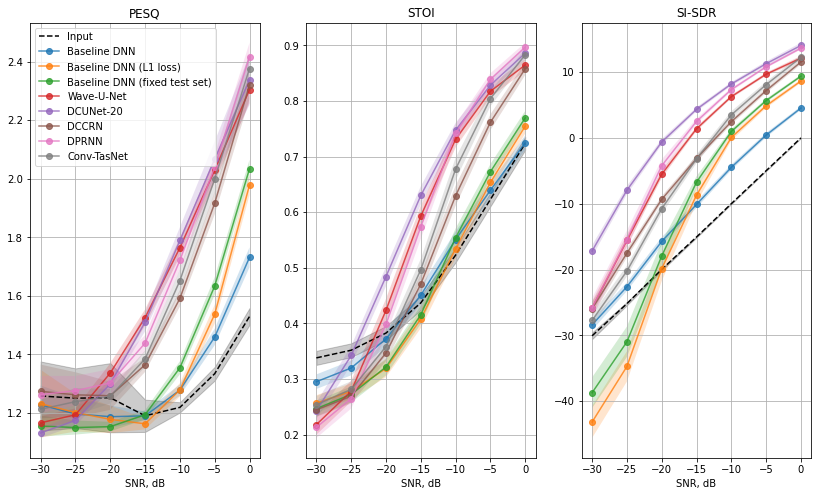

In [21]:
eval_all_and_plot(models, timit_test_small, 'eval_results_new_small', 'results_small_v2.pdf')